<!-- ---
reviewed_on: "2024-11-20"
--- -->

# Inference and validation

**Inference** is the action of using a trained network to make predictions; this term was borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and are not able to generalize to data that has not been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set, called the **validation** set. We avoid overfitting through regularization, such as dropout, while monitoring the validation performance during training.

In [13]:
import helper
import matplotlib.pyplot as plt
import torch
from torch import nn, optim

In [14]:
from torchvision import datasets, transforms


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
								transforms.Normalize((0.5,), (0.5,))
								])
# Download and load the training data
trainset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [15]:
import torch.nn.functional as F


class Classifier(nn.Module):
	def __init__(self):
		super().__init__()
		self.fc1 = nn.Linear(784, 256)
		self.fc2 = nn.Linear(256, 128)
		self.fc3 = nn.Linear(128, 64)
		self.fc4 = nn.Linear(64, 10)

	def forward(self, x):
		# make sure input tensor is flattened
		x = x.view(x.shape[0], -1)

		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = F.relu(self.fc3(x))
		x = F.log_softmax(self.fc4(x), dim=1)

		return x

In [16]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [17]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples

print(top_class[:10,:])

tensor([[1],
        [1],
        [1],
        [1],
        [6],
        [1],
        [6],
        [1],
        [6],
        [1]])


In [18]:
print(labels.shape)
print(top_class.shape)

torch.Size([64])
torch.Size([64, 1])


In [19]:
equals = top_class == labels.view(*top_class.shape)
equals.shape

torch.Size([64, 1])

In [ ]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f"Accuracy: {accuracy.item() * 100}%")

Accuracy: 9.375%


In [21]:
model = Classifier()
criterion = nn.NLLLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30

train_losses, test_losses = [], []
for e in range(epochs):
	tot_train_loss = 0
	for images, labels in trainloader:
		optimizer.zero_grad()

		log_ps = model(images)
		loss = criterion(log_ps, labels)
		tot_train_loss += loss.item()

		loss.backward()
		optimizer.step()
	else:
		tot_test_loss = 0
		test_correct = 0  # Number of correct predictions on the test set

		# Turn off gradients for validation, saves memory and computations
		with torch.no_grad():
			for images, labels in testloader:
				log_ps = model(images)
				loss = criterion(log_ps, labels)
				tot_test_loss += loss.item()

				ps = torch.exp(log_ps)
				top_p, top_class = ps.topk(1, dim=1)
				equals = top_class == labels.view(*top_class.shape)
				test_correct += equals.sum().item()

		# Get mean loss to enable comparison between train and test sets
		train_loss = tot_train_loss / len(trainloader.dataset)
		test_loss = tot_test_loss / len(testloader.dataset)

		# At completion of epoch
		train_losses.append(train_loss)
		test_losses.append(test_loss)

		print("Epoch: {}/{} ".format(e + 1, epochs),
				"Training loss: {:.3f} ".format(train_loss),
				"Test loss: {:.3f} ".format(test_loss),
				"Test accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

Epoch: 1/30  Training loss: 0.514  Test loss: 0.455  Test accuracy: 0.833
Epoch: 2/30  Training loss: 0.392  Test loss: 0.446  Test accuracy: 0.844
Epoch: 3/30  Training loss: 0.354  Test loss: 0.444  Test accuracy: 0.843
Epoch: 4/30  Training loss: 0.333  Test loss: 0.360  Test accuracy: 0.869
Epoch: 5/30  Training loss: 0.317  Test loss: 0.373  Test accuracy: 0.865
Epoch: 6/30  Training loss: 0.302  Test loss: 0.349  Test accuracy: 0.876


KeyboardInterrupt: 

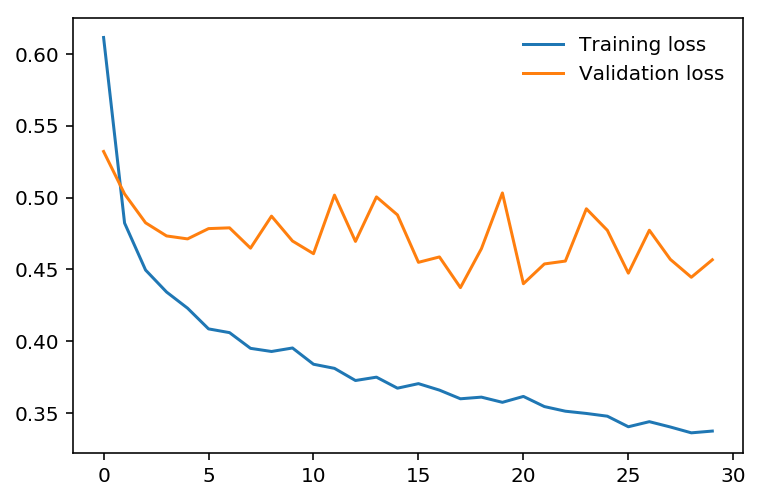

In [ ]:
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.legend(frameon=False)
plt.show()

## Overfitting

Is the phenomenon that occurs when a network learns the training set very well, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing.

One option to avoid this is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called **early-stopping**. The most common method to reduce overfitting (outside of early-stopping) is **dropout**, where we randomly drop input units. This forces the network to share information between weights, increasing its ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we are using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is $0$. You can turn dropout back on by setting the model to train mode with `model.train()`.

In [22]:
class Classifier(nn.Module):
	def __init__(self):
		super().__init__()
		self.fc1 = nn.Linear(784, 256)
		self.fc2 = nn.Linear(256, 128)
		self.fc3 = nn.Linear(128, 64)
		self.fc4 = nn.Linear(64, 10)

		# Dropout module with 0.2 drop probability
		self.dropout = nn.Dropout(p=0.2)

	def forward(self, x):
		# make sure input tensor is flattened
		x = x.view(x.shape[0], -1)

		# Now with dropout
		x = self.dropout(F.relu(self.fc1(x)))
		x = self.dropout(F.relu(self.fc2(x)))
		x = self.dropout(F.relu(self.fc3(x)))

		# output so no dropout here
		x = F.log_softmax(self.fc4(x), dim=1)

		return x

In [ ]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 5
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
	running_loss = 0
	for images, labels in trainloader:

		optimizer.zero_grad()

		log_ps = model(images)
		loss = criterion(log_ps, labels)
		loss.backward()
		optimizer.step()

		running_loss += loss.item()
	else:
		test_loss = 0
		accuracy = 0

		# Turn off gradients for validation, saves memory and computations
		with torch.no_grad():
			model.eval()
			for images, labels in testloader:
				log_ps = model(images)
				test_loss += criterion(log_ps, labels)

				ps = torch.exp(log_ps)
				top_p, top_class = ps.topk(1, dim=1)
				equals = top_class == labels.view(*top_class.shape)
				accuracy += torch.mean(equals.type(torch.FloatTensor))

		model.train()

		train_losses.append(running_loss / len(trainloader))
		test_losses.append(test_loss / len(testloader))

		print("Epoch: {}/{} ".format(e + 1, epochs),
				"Training Loss: {:.3f} ".format(train_losses[-1]),
				"Test Loss: {:.3f} ".format(test_losses[-1]),
				"Test Accuracy: {:.3f} ".format(accuracy / len(testloader)))

Epoch: 1/5  Training Loss: 0.611  Test Loss: 0.468  Test Accuracy: 0.833 
Epoch: 2/5  Training Loss: 0.485  Test Loss: 0.458  Test Accuracy: 0.839 
Epoch: 3/5  Training Loss: 0.452  Test Loss: 0.413  Test Accuracy: 0.849 
Epoch: 4/5  Training Loss: 0.433  Test Loss: 0.412  Test Accuracy: 0.855 
Epoch: 5/5  Training Loss: 0.425  Test Loss: 0.401  Test Accuracy: 0.860 


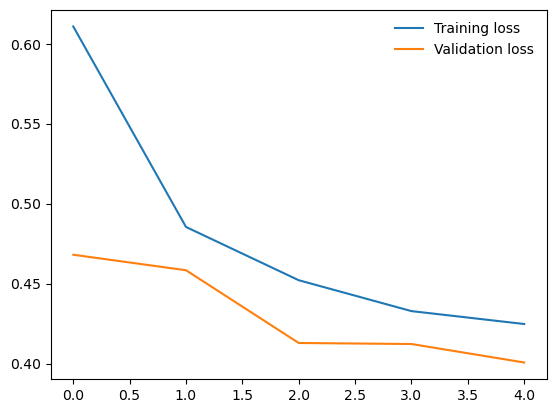

In [24]:
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.legend(frameon=False)

## Inference

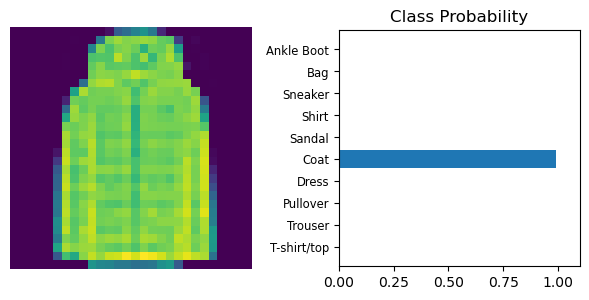

In [26]:
model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
	output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version="Fashion")